### BELOW IS PLAYING AROUND; SHOWING HOW I DERIVED THE CODE

In [3]:
# libraries 
import geopandas as gpd
import numpy as np 
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.mask import mask
import os
import json
from shapely.geometry import box, Polygon
import logging
import random
import torchvision.transforms.functional as TF
import torch

def generate_geoseries( bounds, crs, dims):

    """
    Generates all dim x dim polygons present in the hillshade TIF.
    """

    # height and width of new squares 
    square_dims = dims # 100x100 meters

    # Calculate the number of segments in each dimension (tif width // desired width in pixels!)
    segments_x = 2500 // square_dims # for depth data its 2500
    segments_y = 2500 // square_dims

    # Create an empty list to store the polygons
    polygons = []

    # Iterate over the segments
    for i in range(segments_y):
        for j in range(segments_x):
            # Calculate the coordinates of the segment
            left = bounds.left + j * square_dims
            bottom = bounds.bottom + i * square_dims
            right = left + square_dims
            top = bottom + square_dims

            # Create a polygon for the segment
            polygon = Polygon([(right, bottom), (left, bottom), (left, top), (right, top), (right, bottom)])

            # Append the polygon to the list
            polygons.append(polygon)

    # Create a GeoSeries from the list of polygons
    return gpd.GeoSeries(polygons, crs=crs)

In [17]:
img = rasterio.open('/home/nadjaflechner/Palsa_data/filtered_tifs/hillshade/749_68_2575_2014.tif')
shape_file = "/home/nadjaflechner/Palsa_data/Ground_truth/gt_polygons.shp"
groundtruth_polygs = gpd.read_file(shape_file)

generated_polygons_all = generate_geoseries(img.bounds, img.crs, 200)


In [18]:
d = {'name': [i for i in range(len(generated_polygons_all))]}
generated_polygons_all_df = gpd.GeoDataFrame(d, geometry = generated_polygons_all, crs=generated_polygons_all.crs)

In [19]:
generated_polygons_all.index

RangeIndex(start=0, stop=144, step=1)

In [22]:

for idx, polygon in zip(generated_polygons_all_df.index, generated_polygons_all_df.geometry):

    # see if there is an overlap with ground truths:
    polyg_df = generated_polygons_all_df.iloc[[idx]]
    intersections = gpd.overlay(groundtruth_polygs, polyg_df, how='intersection')

    # only crop if theres a ground truth overlap
    if not intersections.empty:
        print('overlap')
        break


overlap


In [40]:
intersections

,fid,name,geometry
0,1.0,123,"POLYGON ((688156.195 7494544.943, 688156.514 7..."
1,2.0,123,"POLYGON ((688227.545 7494541.272, 688227.864 7..."
2,3.0,123,"POLYGON ((688268.992 7494609.003, 688269.045 7..."
3,4.0,123,"POLYGON ((688299.745 7494626.561, 688299.586 7..."


In [42]:
cropped_data, cropped_transform = mask(img, [polygon], crop=True)

# Update the metadata for the cropped TIF
cropped_meta = img.meta.copy()
cropped_meta.update({"driver": "GTiff",
                    "height": cropped_data.shape[1],
                    "width": cropped_data.shape[2],
                    "transform": cropped_transform})

# Save the cropped TIF file with a unique name
with rasterio.open('/home/nadjaflechner/test.tif', "w", **cropped_meta) as dest:
    dest.write(cropped_data)

In [43]:
cropped_img = rasterio.open('/home/nadjaflechner/test.tif')

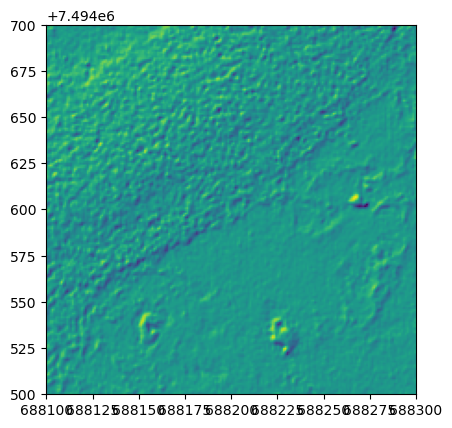

<Axes: >

In [46]:
rasterio.plot.show(cropped_img)

In [47]:
masked_data, _ = mask(cropped_img, [polyg for polyg in intersections.geometry])


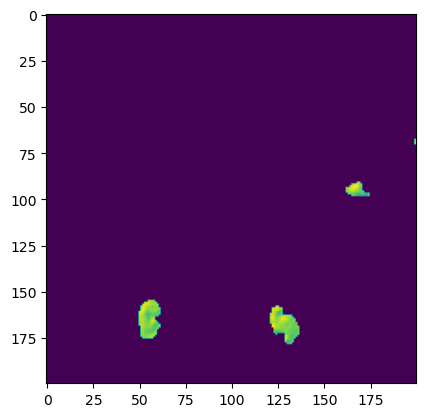

<Axes: >

In [48]:
rasterio.plot.show(masked_data)

In [53]:
masked_data[masked_data >0] = 1

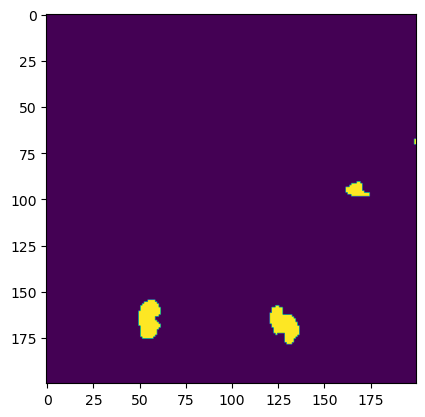

<Axes: >

In [54]:
rasterio.plot.show(masked_data)

In [55]:
masked_data.max()

1

In [56]:
with rasterio.open('/home/nadjaflechner/test_gt.tif', "w", **cropped_img.meta.copy()) as dest:
    dest.write(masked_data)

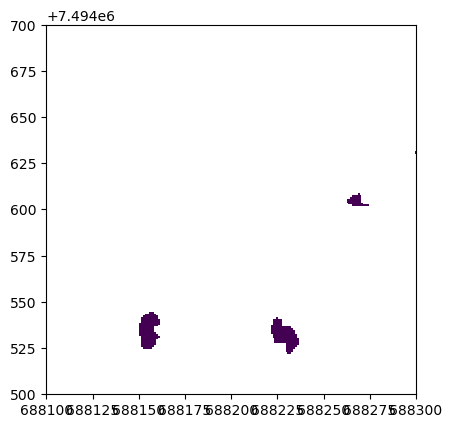

<Axes: >

In [57]:


generated_gt = rasterio.open('/home/nadjaflechner/test_gt.tif')
rasterio.plot.show(generated_gt)

In [60]:
generated_gt.read().max()

1

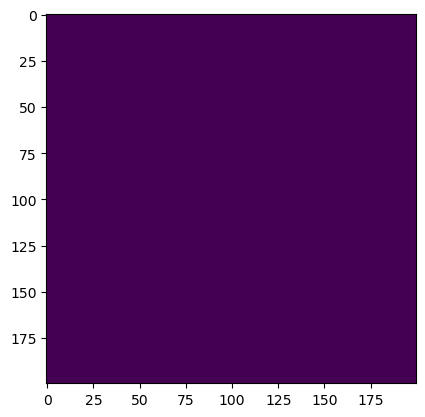

<Axes: >

In [67]:
rasterio.plot.show(generated_gt.read()*0)

In [61]:
new = masked_data

In [64]:
new = new *0

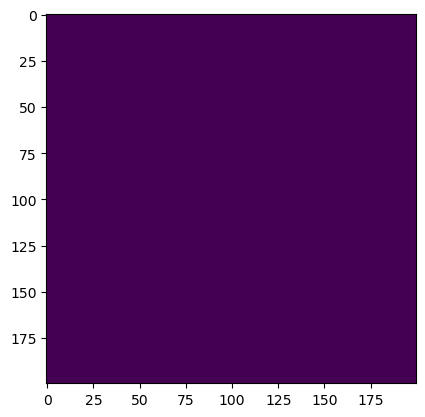

<Axes: >

In [65]:
import rasterio.plot


rasterio.plot.show(new)

### COMPARING GENERATED GROUND TRUTH TO HS

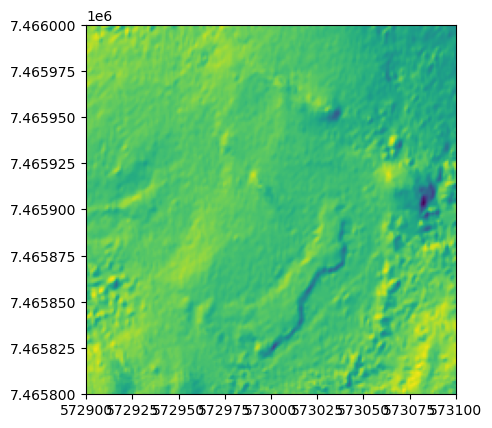

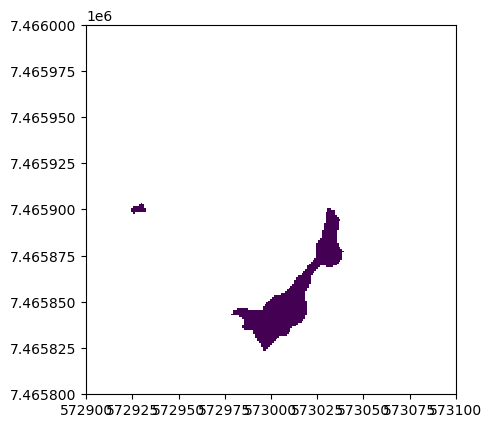

<Axes: >

In [69]:
hs_path = '/home/nadjaflechner/Palsa_data/generated_datasets/FINAL_200m_groundtruths/hs/746_57_5025_2015_crop_50.tif'
gt_path = '/home/nadjaflechner/Palsa_data/generated_datasets/FINAL_200m_groundtruths/groundtruth_mask/746_57_5025_2015_crop_50.tif'

hs_im = rasterio.open(hs_path)
rasterio.plot.show(hs_im)

gt_im = rasterio.open(gt_path)
rasterio.plot.show(gt_im)

In [73]:
gt_im.read().shape

(1, 200, 200)

### Testing during final image generation

In [70]:
import geopandas as gpd

filepath = "/home/nadjaflechner/Palsa_data/Ground_truth_final/Palsa_ground_truth_outlines_SharedNadja.shp"
groundtruth_polygs = gpd.read_file(filepath)


In [71]:
for i in range(len(groundtruth_polygs)):
    try:
        groundtruth_polygs['geometry'][i].bounds
        # print(f'successful counter = {i}')
    except:
        print(f'FAILED at = {i}')


FAILED at = 390
FAILED at = 392


In [72]:
new = groundtruth_polygs.drop([390,392])

In [73]:
len(new)

424

In [75]:
for i in new['geometry']:
    try:
        print(i.bounds)
        # print(f'successful counter = {i}')
    except:
        print(f'FAILED at = {i}')


(688149.8104874288, 7494524.192531442, 688161.7818712636, 7494544.942930089)
(688221.1599350842, 7494520.680925517, 688237.1217801971, 7494541.750561067)
(688261.7562278215, 7494600.809387984, 688275.1109715663, 7494609.003135142)
(688299.4261822891, 7494616.345583896, 688310.2802369662, 7494636.61712719)
(688317.3034488162, 7494610.758938107, 688342.3635456441, 7494646.513471161)
(688347.4713360803, 7494616.664820799, 688372.6910513595, 7494640.2883515665)
(688300.2641791572, 7494605.052578478, 688310.5595692556, 7494614.350353258)
(688501.7824737171, 7494745.277387801, 688540.4101388921, 7494786.1397112915)
(688571.854973766, 7494777.36069648, 688589.8120495189, 7494787.017612773)
(571297.7314407561, 7464413.785644422, 571339.551474954, 7464451.45559889)
(571376.5031463923, 7464224.996921341, 571390.7091885434, 7464238.245252785)
(571487.11873303, 7464330.704240603, 571524.7886874982, 7464370.92809029)
(573543.8423805385, 7462714.288090548, 573551.1050200651, 7462723.067105359)
(5734

In [76]:
invalid = groundtruth_polygs.loc[~groundtruth_polygs.geometry.is_valid]

In [78]:
invalid

,fid,geometry
21,22.0,"POLYGON ((571775.270 7465975.872, 571775.509 7..."
22,23.0,"POLYGON ((573031.477 7465902.066, 573033.183 7..."
49,50.0,"POLYGON ((575911.675 7466959.956, 575912.101 7..."
177,179.0,"POLYGON ((675608.106 7533698.776, 675619.918 7..."
179,181.0,"POLYGON ((675514.130 7533832.402, 675514.477 7..."
206,208.0,"POLYGON ((675721.267 7533577.758, 675723.221 7..."
218,220.0,"POLYGON ((675796.309 7533736.050, 675798.263 7..."
235,237.0,"POLYGON ((663629.428 7587021.457, 663632.359 7..."
284,286.0,"POLYGON ((698166.334 7572469.961, 698171.588 7..."
291,293.0,"POLYGON ((695833.235 7575196.195, 695832.959 7..."


In [79]:
filtered = groundtruth_polygs.drop(invalid.index)

In [80]:
invalid2 = filtered.loc[~filtered.geometry.is_valid]
len(invalid2)

0

In [47]:
groundtruth_polygs['geometry'][392]

In [28]:
groundtruth_polygs['types'].value_counts()

types
1    426
Name: count, dtype: int64

In [13]:
groundtruth_polygs

,fid,geometry,types
0,1.0,"POLYGON ((688153.003 7494543.985, 688156.195 7...",<class 'pandas.core.series.Series'>
1,2.0,"POLYGON ((688224.672 7494541.751, 688227.545 7...",<class 'pandas.core.series.Series'>
2,3.0,"POLYGON ((688267.396 7494608.205, 688268.992 7...",<class 'pandas.core.series.Series'>
3,4.0,"POLYGON ((688303.097 7494634.861, 688306.769 7...",<class 'pandas.core.series.Series'>
4,5.0,"POLYGON ((688326.721 7494645.077, 688329.754 7...",<class 'pandas.core.series.Series'>
...,...,...,...
421,424.0,"POLYGON ((743385.541 7652606.825, 743401.049 7...",<class 'pandas.core.series.Series'>
422,425.0,"POLYGON ((743440.916 7652483.858, 743451.304 7...",<class 'pandas.core.series.Series'>
423,426.0,"POLYGON ((743403.275 7652041.122, 743399.861 7...",<class 'pandas.core.series.Series'>
424,427.0,"POLYGON ((742589.997 7651842.813, 742601.174 7...",<class 'pandas.core.series.Series'>


In [6]:
types = [type(i) for i in lissie]

In [7]:
types

[shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.polygon.Polygon,
 shapely.geometry.po

In [10]:
uniques = []

AttributeError: 'list' object has no attribute 'unique'

In [97]:
import rasterio
import rasterio.plot

test_gt = rasterio.open(
    "/home/nadjaflechner/Palsa_data/generated_datasets/FINALFINAL_200m_groundtruths/groundtruth_mask/753_67_2550_2014_crop_63.tif")
test_rgb = rasterio.open(
    "/home/nadjaflechner/Palsa_data/generated_datasets/FINALFINAL_200m_groundtruths/rgb/753_67_2550_2014_crop_63.tif")

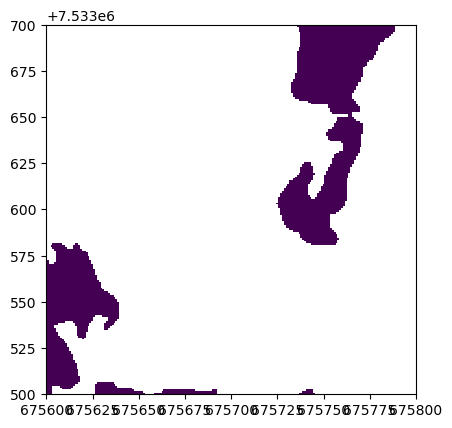

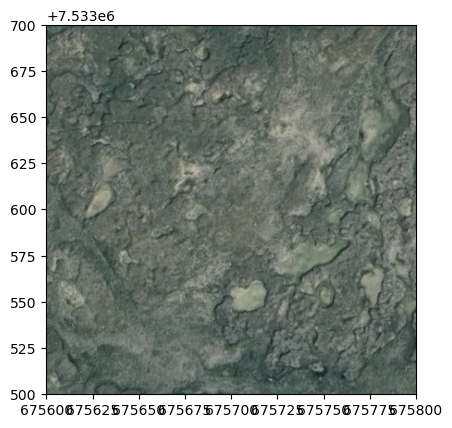

<Axes: >

In [98]:
rasterio.plot.show(test_gt)
rasterio.plot.show(test_rgb)

In [109]:
test_gt = rasterio.open(
    "/home/nadjaflechner/Palsa_data/generated_datasets/FINALFINAL_200m_groundtruths/groundtruth_mask/753_67_2550_2014_crop_63.tif")
img = test_gt.read()
palsa_pixels = img.sum()
total_pixels = img.shape[-1]*img.shape[-2]
percent = palsa_pixels/total_pixels * 100



In [110]:
percent

14.042499999999999

### Calculate the amount of palsa in ground truth and as estimated label. 